# Implementing a GP prior on Height

I'm going to try and implement a Gaussian Process prior on Height H as done by Guy in his previous examples.

We'll build this around the main assumption that the heights are distributed as a Gaussian

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u

import corner
import pystan
import pickle
import os

Lets read in a handful of modes

In [2]:
locs = np.genfromtxt('locs.txt')
mid = int(np.floor(len(locs)/2))
l0s = locs[mid:mid+1,0]
l1s = locs[mid:mid+1,1]
l2s = locs[mid-1:mid,2]
modelocs = np.array([l0s, l1s, l2s]).flatten()
modeids = [0]*len(l0s) + [1]*len(l1s) + [2]*len(l2s)

In [3]:
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')
sel = [(ff >= np.min(modelocs)-25) & (ff <= np.max(modelocs+25))]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

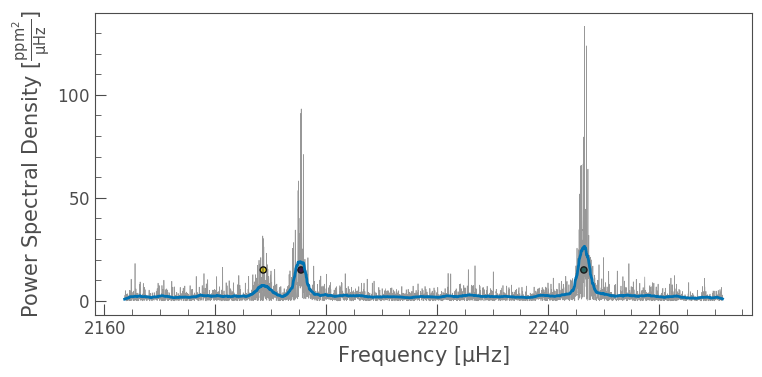

In [ ]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

## Treating $H$

We can nominally treat the height of the $l=0$ modes as a Gaussian function centered at $\nu_{\rm max}$ with a spread $\sigma$ equal to:

$\sigma = \large\frac{0.25 * \nu_{\rm max}}{2.355}$ ,

for a Main Sequence star.

In reality, the true distribution of heights may vary on a star-by-star basis. In order to account for this, we will use a Gaussian Process as a prior on height, which will marginalise over all functions that could describe the height.

We will use a squared exponential kernel as

$K_{i, j} = \alpha^2 \times \exp\left(\frac{-(\nu_i - \nu_j)^2}{2\rho^2}\right)$ ,

where we will allow $\alpha$ to vary as a free parameter and fix $\rho$ as equal to $\sigma$. The GP will have a mean equal to the Gaussian description of the mode heights.

In [ ]:
overwrite = False
gph = '''
functions{      
    vector lorentzian(real loc, int l, int m, vector f, real eps, real H, real w, real nus){
        return (eps * H) ./ (1 + (4/w^2) * square(f - loc + m*nus));
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    vector[N] f;      // Frequency
    vector[N] p;      // Power
    real asy_locs[M]; // Mode locations (this will have to change for multiple n modes)
    int asy_ids[M];   // The ID's of the modes
    real numax;       // The large frequency separation
}
parameters{
    vector<lower=0.>[M] A;  // Mode amplitude
    real logGamma[M];       // Mode linewidth in log space
    real locs[M];           // True mode locations
    real vsini;             // Line of sight rotational frequency
    real<lower=0.> nus;     // Rotational frequency splitting
    real<lower=0.1> b;      // Background
    real<lower=0.> alpha;   // Spread on the squared exponential kernel
}
transformed parameters{
    real H[M];       // Mode height
    real w[M];       // Mode linewidth
    
    for (m in 1:M){
        w[m] = 10^logGamma[m];             // Transform mode linewidth from log space
        H[m] = A[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    vector[N] modes; // Our Model
    real i;          // Angle of inclination (rad)
    matrix[4,4] eps; // Matrix of legendre polynomials
    cov_matrix[M,M] gpa; // Covariance Matrix of the mode amplitudes
    int l;           // The radial degree
    
    // First we'll calculate all the legendre polynomials for this i
    i = asin(vsini / nus);
    eps = rep_matrix(1., 4, 4);
    eps[0+1,0+1] = 1.;
    eps[1+1,0+1] = cos(i)^2;
    eps[1+1,1+1] = 0.5 * sin(i)^2;
    eps[2+1,0+1] = 0.25 * (3. * cos(i)^2 - 1.)^2;
    eps[2+1,1+1] = (3./8.)*sin(2*i)^2;
    eps[2+1,2+1] = (3./8.) * sin(i)^4;
    eps[3+1,0+1] = (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
    eps[3+1,1+1] = (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
    eps[3+1,2+1] = (15./8.)*cos(i)^2 * sin(i)^4;
    eps[3+1,3+1] = (5./16.)*sin(i)^6;    

    
    // Generating the GP prior on linewidth
    gpa = cov_exp_quad(locs, alpha, 0.25*numax/2.355);
    
    // Generating our model
    modes = rep_vector(b, N);
    for (mode in 1:M){        // Iterate over all modes passed in
        l = asy_ids[mode];    // Identify the Mode ID
        for (m in -l:l){      // Iterate over all m in a given l
            modes += lorentzian(locs[mode], l, m, f, eps[l+1,abs(m)+1], H[mode], w[mode], nus);
        }
    }

    // Model drawn from a gamma distribution scaled to the model (Anderson+1990)
    p ~ gamma(1., 1../modes);
    
    //priors on the parameters
    logGamma ~ normal(0, .05);
    locs ~ normal(asy_locs, 1);
    nus ~ normal(0.411, 0.1);
    vsini ~ uniform(0.,nus);
    
    alpha ~ normal(1., 1.);
    A ~ multi_normal(rep_vector(15., M), gpa);
    
    b ~ normal(1.,.1);
}
'''
model_path = 'gph.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = gph, model_name='gph')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = gph, model_name='gph')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

Reading in Stan model


In [ ]:
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
dnu = 102. #uHz

data = {'N':len(f),
        'M': len(modelocs),
        'f':f,
        'p':p,
        'asy_locs':modelocs,
        'asy_ids':modeids,
        'numax':2200.}

init = {'logGamma' : np.zeros(len(modelocs)),
        'vsini':nus*np.sin(i),
        'nus':nus,
        'locs' : modelocs,
        'alpha': 1.17}

In [ ]:
nchains = 4
fit = sm.sampling(data=data, iter=500, chains=nchains,verbose=False, init = [init for n in range(nchains)])

In [ ]:
print(fit)

In [ ]:
fit.plot(pars=['vsini','nus','H','A','logGamma','alpha'])
plt.show()

In [ ]:
truths= [init['vsini'],init['nus'], np.nan, np.nan]
labels=['vsini','nus', 'b', 'alpha']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, quantiles=[0.16, 0.5, 0.84],
            truths=truths,show_titles=True)
plt.show()

for idx in range(len(fit['H'].T)):
    chain = np.array([fit['H'].T[idx], fit['w'].T[idx]])
    corner.corner(chain.T, labels=['H','w'], quantiles=[0.16, 0.5, 0.84],show_titles=True)
    print('l = {}'.format(modeids[idx]))   
    plt.show()

In [ ]:
def get_epsilon(i, l, m):
#I use the prescriptions from Gizon & Solank 2003 and Handberg & Campante 2012
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.5 * np.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * np.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*np.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * np.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * np.cos(i)**2 * np.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*np.sin(i)**6
    
def lorentzian(f, l, m, loc, i, H, w, nus):
    eps = get_epsilon(i,l,m)
    model = eps * H / (1 + (4/w**2)*(f - loc + m * nus)**2)
    return model

model = np.ones(len(f))
nus = np.median(fit['nus'])
for mode in range(len(modeids)):
    l = modeids[mode]
    for m in range(-l, l+1):
        loc = np.median(fit['locs'].T[mode])
        H = np.median(fit['H'].T[mode])
        w = np.median(fit['w'].T[mode])
        model += lorentzian(f, l, m, modelocs[mode], i, H, w, nus)
fitlocs = np.median(fit['locs'],axis=0)

In [ ]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5, label='Data')
plt.scatter(fitlocs, [15]*len(fitlocs),c=modeids,s=20)
plt.scatter(modelocs, [15]*len(modelocs),c='r')
plt.plot(f, model, linewidth=1, label='Model')
plt.legend()